# Анализ результатов А/А/В теста


**Цель исследования** - изучить воронку продаж мобильного приложения стартапа, занимающегося продажей продуктов питания, исследовать результаты А/А/В-теста: пользователи мобильного приложения разделены на 3 группы: 2 контрольных (без изменений) и 1 тестовая (изменены шрифты оформления мобильного приложения).

Результатами исследования станут: определение эффекта от внедрения изменений шрифтов в оформление мобильного приложения: анализ результатов А/А/В теста.

## Обзор и предобработка данных

Изучим данные и выполним их предобработку: при необходимости приведем наименования столбцов к единому стилю, проверим соответствие типов данных сохранённым в них значениям, проверим наличие в данных пропусков и дубликатов.

### Обзор данных

Импортируем библиотеки необходимые нам в решении задач исследования.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as st
from plotly import graph_objects as go
import plotly.express as px
import math as mth


# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
#улучшим четкость изображения графиков
%config InlineBackend.figure_format = 'retina'

In [3]:
import plotly.io as pio
pio.renderers.default = 'png'
svg_renderer = pio.renderers['png']
svg_renderer.scale = 1.2

Ознакомимся с данными:

In [4]:
data = pd.read_csv('logs_exp.csv', sep='\t')

display(data.info(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Согласно документации к данным структура `data`:
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

По первому взгляду на датасет можно сделать следующие **выводы:**
* типы данных не соответствуют сохраненным в них значениям: столбец с датами определен как тип данных `int64`
* наименования стобцов требуют предобработки: переименования, приведения к единому стилю написания (нижний регистр, змеиный язык), для удобства дальнейшей работы с ними.

### Предобработка данных

Переименуем столбцы (приведем их наименования к единому стилю), преобразуем данные о времени, а также добавим столбец с датой, он пригодится нам для дальнейшего исследования:

In [5]:
#переименование столбцов
data = data.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'user_id',
       'EventTimestamp':'event_dt', 'ExpId':'group'})

#преобразование данных о времени
data['event_dt'] = pd.to_datetime(data.event_dt, unit='s')

#добавляем новый столбец с датой
data['date'] = pd.to_datetime(data['event_dt']).dt.date

#добавляем новый столбец с датой и часом
data['hour'] = data['event_dt'].dt.strftime('%Y-%m-%d %H')

In [6]:
#проверка названий столбцов и типов данных
display(data.info(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_dt    244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   date        244126 non-null  object        
 5   hour        244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


None

,event_name,user_id,event_dt,group,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,2019-07-25 04
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,2019-07-25 11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,2019-07-25 11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,2019-07-25 11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,2019-07-25 11


In [7]:
#проверим датасет на наличие пропущенных значений
data.isna().sum()

event_name    0
user_id       0
event_dt      0
group         0
date          0
hour          0
dtype: int64

Пропущенных значений нет.

In [8]:
#проверим датасет на наличие явных дубликатов
data.duplicated().sum()

413

In [9]:
#доля явных дубликатов
round(data.duplicated().sum() / data.shape[0] *100, 2)

0.17

Доля явных дубликатов в датасете составляет менее 0,2%. Удалим дубликаты из датасета:

In [10]:
data = data.drop_duplicates()

## Изучение и проверка данных

### Общая информация

Определим некоторую справочную информацию о наших данных:

In [11]:
#временные рамки
display(data['event_dt'].min())
display(data['event_dt'].max())
 
#справка о пользователях
display('Количество событий в логе:', data['event_name'].count())
display('Количество пользователей в логе:', data['user_id'].nunique())
display('Количество в среднем событий на 1 пользователя:', 
        round(data.groupby('user_id')['event_name'].agg('count').mean()), 0)

Timestamp('2019-07-25 04:43:36')

Timestamp('2019-08-07 21:15:17')

'Количество событий в логе:'

243713

'Количество пользователей в логе:'

7551

'Количество в среднем событий на 1 пользователя:'

32

0

Мы располагаем данными в период с 25 июля по 7 августа 2019 года. Датасет содержит информацию о 243 713 событий, 7551 пользователе. В среднем на 1 пользователя приходится 32 события.

### Определение полных данных

Проверим данные на их полноту, для этого построим гистограмму и посмотрим как распределяется количество событий по времени:

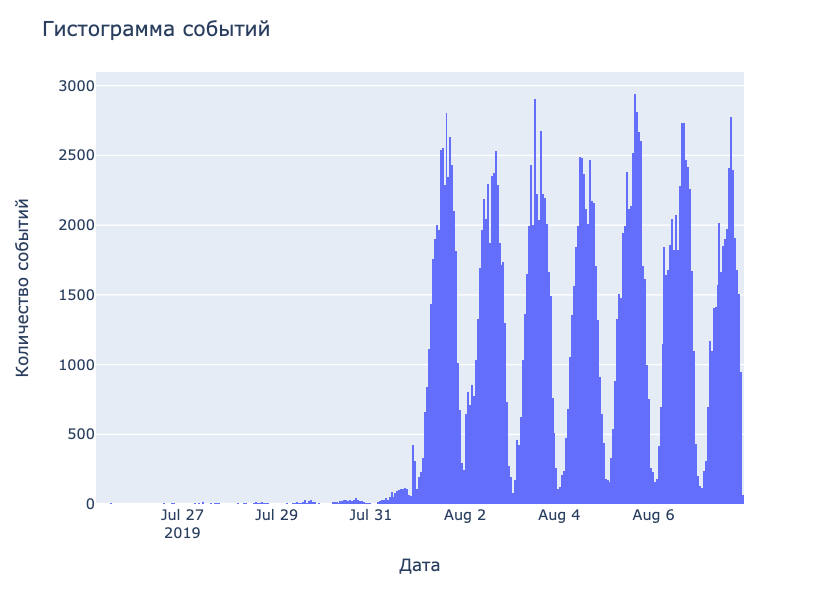

In [12]:
fig = px.histogram(data, x='event_dt')
#оформление графика
fig.update_layout(title='Гистограмма событий',
                   xaxis_title='Дата',
                   yaxis_title='Количество событий')

fig.show()

In [13]:
#data['event_dt'].hist(figsize=(15, 7.5), bins=500, color='#0000CD');

По графику можно сделать следующие **выводы:** 

Полные данные включает период с 1 августа по 7 августа 2019 года, вероятно это связано с тем что данные "доезжают" для пользователей из прошлого.

Отбросим неполноценные данные до 1 августа 2019 года и не будем учитывать их в исследовании, обозначим потери:

In [14]:
#датасет с полными данными, период 1 августа - 7 августа 2019 года включительно
full_data = data[(data['event_dt'] > '2019-08-01')]

display('Количество событий в логе:', full_data['event_name'].count())
display('Количество пользователей в логе:', full_data['user_id'].nunique())
display('Количество в среднем событий на 1 пользователя:', 
        round(full_data.groupby('user_id')['event_name'].agg('count').mean()), 0)

display('Доля исключенных из исследования событий (%):', 
        round((1 - full_data['event_name'].count() / data['event_name'].count()) * 100 , 2))
display('Доля исключенных из исследования пользователей (%):', 
        round((1 - full_data['user_id'].nunique() / data['user_id'].nunique()) * 100 , 2))

'Количество событий в логе:'

240887

'Количество пользователей в логе:'

7534

'Количество в среднем событий на 1 пользователя:'

32

0

'Доля исключенных из исследования событий (%):'

1.16

'Доля исключенных из исследования пользователей (%):'

0.23

Данные с актуализированным периодом исследования включают себя: информацию о 240 887 событий, 7534 пользователей в период с 1 августа по 7 августа 2019 года включительно. В среднем на 1 пользователя приходится 32 события.

Потери в связи с сокращением периода для дальнейшего исследования составляют:
чуть более 1% (1,16%) событий и менее 1%(0,23%) пользователей.

Проверим наличие пользователей из всех трех групп эксперимента в данных для дальнейшего исследования.

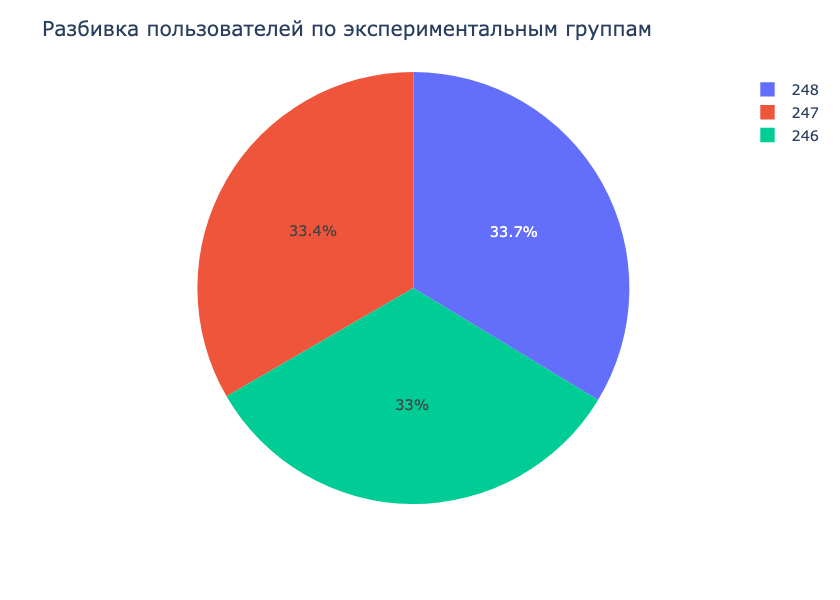

In [15]:
#сгруппируем данные по группам эксперимента и посчитаем количество уникальных пользователей
data_per_group = full_data.groupby('group')[['user_id']].agg('nunique')
#переименуем столбец
data_per_group.columns = ['total_count']
data_per_group = data_per_group.reset_index()

#круговая диаграмма по собранным данным
fig = px.pie(data_per_group, values='total_count', names='group')

#оформление графика
fig.update_layout(title='Разбивка пользователей по экспериментальным группам')
fig.show()

In [16]:
# full_data.groupby('group')['user_id'].agg('nunique').plot(kind='pie',
#                                                           figsize= (5, 5),
#                                                           title= 'Разбивка пользователей по экспериментальным группам', 
#                                                           legend=True, 
#                                                           labels=None, 
#                                                           autopct='%1.0f%%',
#                                                           cmap = 'coolwarm');

Разбивка уникальных пользователей по группам эксперимента подтверждает, что в срезе данных, который будет использоваться в дальнейшем исследовании присутствуют пользователи из всех трех экспериментальных групп, при этом их доли примерно равны (приблизительно по 33% пользователей от общего количества пользователей исследования в каждой группе).

## Изучение воронки событий

### Частота событий

Проведем исследовательский анализ данных: определим частоту каждого события в исследуемых данных.

Соберем данные необходимые нам для дальнейшего исследования, определим количество событий `event_count`, количество пользователей по событиям `users_count` и процент пользователей совершивших целевое действие (по событиям)- `cr`.

In [17]:
#собираем данные
df = full_data.groupby('event_name').agg({
    'date' : 'count',
    'user_id' : 'nunique'
}).sort_values(by='user_id', ascending=False).reset_index()

df.columns = ['event_name', 'events_count', 'users_count']

df['cr'] = round(df['users_count'] / full_data['user_id'].nunique() * 100, 2)

df

,event_name,events_count,users_count,cr
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


Дадим определения событий:
* `Tutorial` - экран руководства пользования
* `MainScreenAppear` - экран главной страницы
* `OffersScreenAppear` - экран каталога продукции
* `CartScreenAppear`  - экран корзины
* `PaymentScreenSuccessful` - экран успешной оплаты

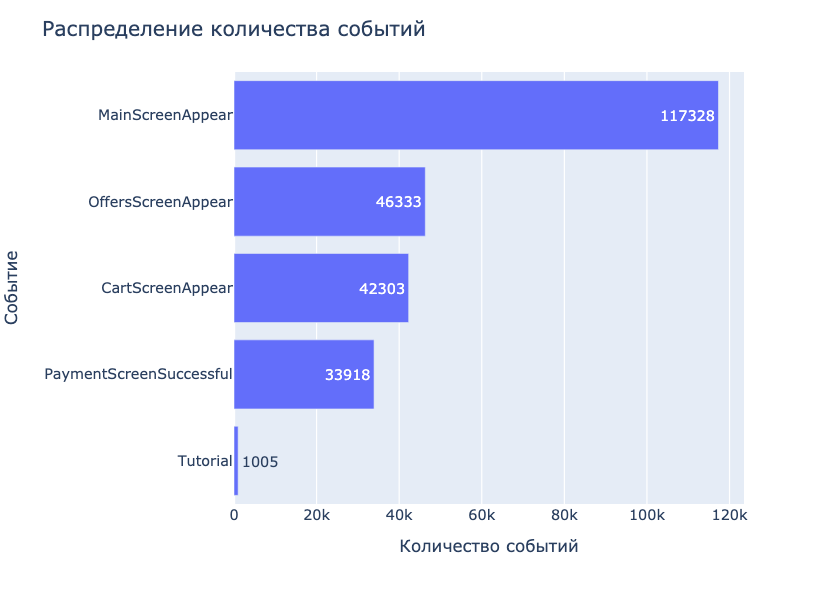

In [18]:
#строим график распределения количества событий
fig = px.bar(df.sort_values(by='events_count', ascending=True), 
             x='events_count',
             y='event_name',
             text='events_count' 
            )

#оформление графика
fig.update_layout(title='Распределение количества событий',
                   xaxis_title='Количество событий',
                   yaxis_title='Событие')
fig.show()

**Выводы**:
* Наиболее частое событие - появление экрана главной страницы (117 328 событий в исследуемых данных)
* На втором месте по частоте - появление экрана каталога продукции (46 333 событий)
* Далее следует экран корзины (42 303 событий)
* Затем экран успешной оплаты (33 918 событий)
* При этом экран руководства пользования появляется с наименьшей частотой (1 005 событий), из чего следует что для того чтобы попасть на экран главной страницы необязательно открывать экран руководства пользования. 

### Распределение пользователей по событиям

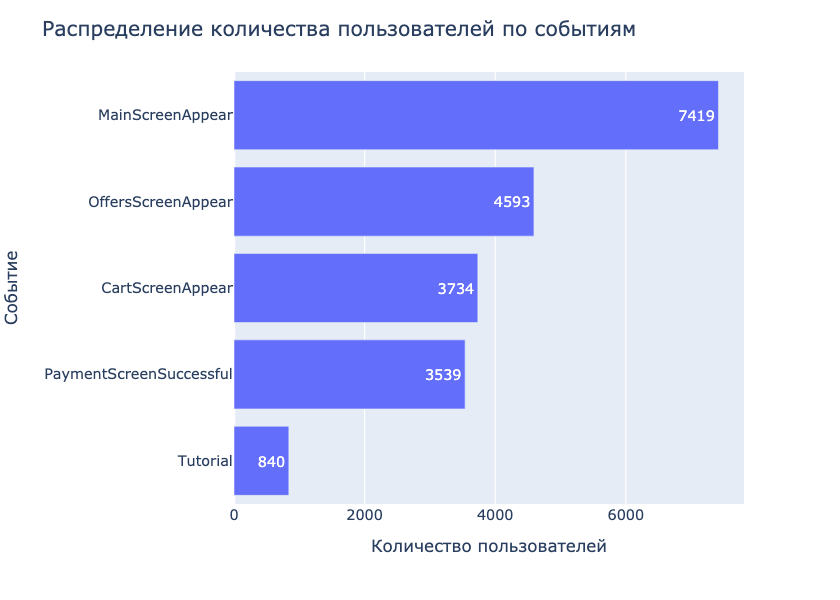

In [19]:
#строим график распределения количества пользователей по событиям
fig = px.bar(df.sort_values(by='events_count', ascending=True), 
             x='users_count',
             y='event_name',
             text='users_count' 
            )

#оформление графика
fig.update_layout(title='Распределение количества пользователей по событиям',
                   xaxis_title='Количество пользователей',
                   yaxis_title='Событие')
fig.show()

**Выводы:**
* 7419 пользователей (около 98% от их общего количества) хотя бы раз доходили до главного экрана. Около 2% пользователей потерялись на этом шаге, возможно имеют места быть некорректное отображение или ошибки для некоторых устройств.
* 4593 пользователей доходят до экрана каталога продукции это 61% всех пользователей
* 3734 пользователей доходят до экрана корзины это около 50% всех пользователей
* 3539 (чуть менее 47% всех пользователей) доходят до экрана успешной оплаты
* 840 пользователей доходят до экрана руководства пользования это 11% всех пользователей

### Воронка событий

Предположим пользователь совершает действия в следующем порядке:
* Шаг первый: открывает экран главной страницы
* Шаг второй: открывает каталог продукции (выбирает продукты, добавляет в корзину)
* Шаг третий: открывает экран корзины 
* Шаг четвертый: оплачивает покупки - экран успешной оплаты заказа

Как было отмечено ранее событие `Tutorial` - открытие руководства пользования является необязательным шагом для пользования сайтом и совершения других действий, поэтому не будем учитывать это событие в дальнейшем исследовании.

Построим воронку событий по конверсии пользователей

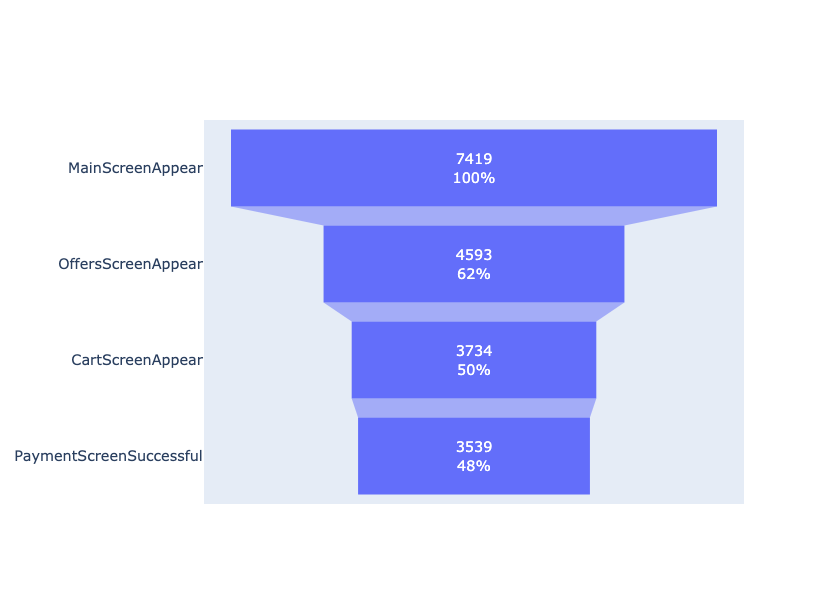

In [20]:
#строим воронку событий для всех пользователей участвующих в эксперименте

fig = go.Figure(go.Funnel(
    name = 'Воронка сбытий',
    y = df[df['event_name'] != 'Tutorial']['event_name'],
    x = df['users_count'],
    textinfo = 'value+percent initial'
#     marker = {'color': ['#0000CD', '#B22222', '#FFA07A', '#8FBC8F']}
))
fig.show();

Добавим новую метрику в нашу таблицу - процент пользователей совершивших целевое действие в шаг `cr_per_step`.

In [21]:
#исключаем событие `Tutorial`

df = df[df['event_name'] != 'Tutorial']


df.loc[0, 'cr_per_step'] = 100
df.loc[1, 'cr_per_step'] = round(df.loc[1, 'users_count'] / df.loc[0, 'users_count'] * 100, 2)
df.loc[2, 'cr_per_step'] = round(df.loc[2, 'users_count'] / df.loc[1, 'users_count'] * 100, 2)
df.loc[3, 'cr_per_step'] = round(df.loc[3, 'users_count'] / df.loc[2, 'users_count'] * 100, 2)

df

/var/folders/p9/hd85ljb13pd1wq837gsp4xjw0000gn/T/ipykernel_89670/523521106.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,event_name,events_count,users_count,cr,cr_per_step
0,MainScreenAppear,117328,7419,98.47,100.00
1,OffersScreenAppear,46333,4593,60.96,61.91
2,CartScreenAppear,42303,3734,49.56,81.30
3,PaymentScreenSuccessful,33918,3539,46.97,94.78


**Вывод:** 
* Около 62% пользователей переходят с главного экрана в каталог продукции (потеря около 38% от количества пользователей увидевших главную страницу)
* 81% из перешедших в каталог продукции переходят в корзину (потеря 19% от пользователей предыдущего шага)
* Около 95% пользователей доходят до экрана успешной оплаты (потеря 5% от пользователей предыдущего шага)

Наибольшее число пользователей теряется на шаге перехода на экран каталога продукции с главной страницы, стоит выяснить причину, возможно приложение работает некорректно на некоторых устройствах.

В целом около 47% пользователей доходит от первого (экран главной страницы) до последнего шага (экран успешной оплаты) воронки.

## Изучение результатов исследования

### Проверка экспериментальных групп

Определим количество пользователей в каждой экспериментальной группе.

In [22]:
users_count = {
    246: full_data[full_data['group']==246]['user_id'].nunique(),
    247: full_data[full_data['group']==247]['user_id'].nunique(),
    248: full_data[full_data['group']==248]['user_id'].nunique(),
    '246+247': full_data[(full_data['group']==246) | (full_data['group']==247)]['user_id'].nunique()}

users_count

{246: 2484, 247: 2513, 248: 2537, '246+247': 4997}

Пользователи распределяются по группам следующим образом:
* группа 246 - 2484 пользователя
* группа 247 - 2513 пользователей
* группа 248 - 2537 пользователей

Из чего можно сделать вывод что количество пользователей в группах сбалансировано.

In [23]:
#подготовим удобные таблицы для проведения теста

#выделим события
events = (df[df['event_name'] != 'Tutorial']
         .sort_values('events_count', ascending=False)['event_name']
         .reset_index(drop=True))

#соберем данные для статистической проверки 
groups = [246, 247, 248]
test_group = {}

for group in groups:
    test_group[group] =[]
    
    for event in events:
        
        test_group[group].append(
            full_data[(full_data['group'] == group) & (full_data['event_name'] == event)]['user_id'].nunique()
        )
        
#объединим данные 246 и 247 группы и добавим их как четвертую тестовую группу
test_group = pd.DataFrame(test_group)
test_group['246+247'] = test_group[246] + test_group[247]
test_group['event_name'] = events

test_group

,246,247,248,246+247,event_name
0,2450,2476,2493,4926,MainScreenAppear
1,1542,1520,1531,3062,OffersScreenAppear
2,1266,1238,1230,2504,CartScreenAppear
3,1200,1158,1181,2358,PaymentScreenSuccessful


Частота событий распределяется схоже для всех трех экспериментальных групп, характерных отклонений от общей тенденции распределения нет.

Также проверим наличие технических ошибок в распределяющей системе теста, т.е. проверим наличие пользователей, участвовавших в нескольких группах теста одновременно:

In [24]:
#находим количество уникальных групп для каждого пользователя 
#фильтруем пользователей с более чем 1 группой
bug_users = full_data.pivot_table(
    index = 'user_id', 
    values = 'group', 
    aggfunc = 'nunique').query('group > 1')

display(bug_users.head())

display('Количество пользователей с ошибками:', bug_users.shape[0])
display('Доля пользователей с ошибками (%):', 
        round(bug_users.shape[0] / full_data['user_id'].nunique() * 100, 2))

,group
user_id,


'Количество пользователей с ошибками:'

0

'Доля пользователей с ошибками (%):'

0.0

Технических ошибок в распределяющей системе теста нет.

### Проверка статистических гипотез

Мы располагаем данными о двух контрольных группах А/А эксперимента 246 и 247. Проверим, находят ли статистические критерии разницу между этими выборками. Для этого проведем тест с использованием z-критерия: проверим гипотезу о равенстве долей двух совокупностей.

Сформулируем гипотезы:

`Нулевая: доли групп равны` 

`Альтернативная: есть различия в долях групп`

In [25]:
#создадим универсальную функцию для проведения теста с использованием z-критерия:
#которая будет принимать на вход номер группы и брать данные из таблиц выше
def check_hypothesis(first_group, second_group, alpha=0.05):
    
    for i in test_group.index:
        
        #пропорция успехов в первой группе:
        p1 = test_group[first_group][i] / users_count[first_group]
        
        #пропорция успехов во второй группе:
        p2 = test_group[second_group][i] / users_count[second_group]
        
        #пропорция успехов в комбинированном датасете:
        p_combined = ((test_group[first_group][i] + test_group[second_group][i]) / 
                      (users_count[first_group] + users_count[second_group]))
        
        #разница пропорций в датасетах
        difference = p1 - p2
        
        #считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_count[first_group] + 1/users_count[second_group]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print(distr.cdf(abs(z_value)))
        
        display('Событие: {}, p-значение: {}'.format(test_group['event_name'][i], p_value))
        
        if (p_value < alpha):
            display('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            display('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('')
        
        
check_hypothesis(246, 247)

0.621470138397695


'Событие: MainScreenAppear, p-значение: 0.7570597232046099'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.875952271073891


'Событие: OffersScreenAppear, p-значение: 0.2480954578522181'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.8855831388100139


'Событие: CartScreenAppear, p-значение: 0.22883372237997213'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.9427166034342908


'Событие: PaymentScreenSuccessful, p-значение: 0.11456679313141849'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

**Вывод:** статистически значимого различия между группами 246 и 247 нет ни для одного события, следовательно обе эти группы можно принимать как контрольные.

Также по очереди протестируем контрольные группы 246 и 247 с группой с измененными шрифтами 248, которая и является тестовой.

In [26]:
#проводим тест для групп 246 и 248

check_hypothesis(246, 248)

0.8525139033222724


'Событие: MainScreenAppear, p-значение: 0.2949721933554552'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.8958189729863054


'Событие: OffersScreenAppear, p-значение: 0.20836205402738917'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.9607853838123994


'Событие: CartScreenAppear, p-значение: 0.07842923237520116'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.8938723362151102


'Событие: PaymentScreenSuccessful, p-значение: 0.2122553275697796'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

**Вывод:** статистически значимого различия между контрольной группой 246 и экспериментальной группой 248 нет ни для одного события.

In [27]:
#проводим тест для групп 247 и 248

check_hypothesis(247, 248)

0.7706473191689243


'Событие: MainScreenAppear, p-значение: 0.4587053616621515'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.540109108470387


'Событие: OffersScreenAppear, p-значение: 0.9197817830592261'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.7106901060230109


'Событие: CartScreenAppear, p-значение: 0.5786197879539783'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.6313292473098018


'Событие: PaymentScreenSuccessful, p-значение: 0.7373415053803964'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

**Вывод:** статистически значимого различия между контрольной группой 247 и экспериментальной группой 248 нет ни для одного события.

Аналогично определим наличие статистически значимого различия между тестовой группой 248 и объединенными вместе контрольными группами 246 и 247:

In [28]:
#проводим тест для групп 248 и 246+247

check_hypothesis('246+247', 248)

0.8528773658141021


'Событие: MainScreenAppear, p-значение: 0.29424526837179577'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.7828722517240587


'Событие: OffersScreenAppear, p-значение: 0.43425549655188256'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.9091206235779781


'Событие: CartScreenAppear, p-значение: 0.18175875284404386'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'


0.6997852858845648


'Событие: PaymentScreenSuccessful, p-значение: 0.6004294282308704'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

**Вывод:** статистически значимого различия между объединенными контрольными группами 246 и 247 и экспериментальной группой 248 нет ни для одного события.

## Результаты исследования

Подведем итог проделанной работы:

   1. При **первичном знакомстве с данными** и оценке их качества было выявлено не соответствие типов данных сохраненным в них значениям, а также разобщенность стилистики наименования столбцов в датасетах. Обнаруженные недочеты были устранены.
   
   
   2. В ходе первой части **исследовательского анализа данных** нами был рассмотрены временные рамки проведения эксперимента и полнота данных. Результатами этого этапа стало исключение неполноценных данных из дальнейшего исследования.

   Во второй части исследовательского анализа данных были подробнее рассмотрены изучаемые события, их распределение между группами участвующими в тестировании, а также количество пользователей приходящиеся на события. Результатом этого этапа столо составление воронки событие и выявление "узкого" места: наибольшее число пользователей (около 38% от количества пользователей увидевших главную страницу) теряется на шаге перехода на экран каталога продукции с главной страницы, стоит выяснить причину, возможно приложение работает некорректно на некоторых устройствах.
   
   
   3. Заключительной частью нашей работы стало **изучение результатов исследования**: нами было произведено 16 проверок статистических гипотез: 4 проверки между контрольными группами, 12 проверок между контрольными группами и группой с изменённым шрифтом (тестовой). Ни одна из проверок не выявила статистически значимой разницы между группами. 
   
   Проверки статистических гипотез производились при уровне значимости 0.05, т.к. при уровне статистической значимости 0.1 каждый десятый раз можно получать ложный результат.
   
   Резюмируя результаты эксперимента: изменение шрифта на сайте не несут значимого эффекта в поведении пользователей ни в худшую ни в лучшую стороны.
